#### **<u>Prep CESM Data </u>**


**Tech Preamble**

In [35]:

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

from esn_dev import detrend

#### **Step 1 - Select Area**

load **one** Dataset and find indices

In [36]:
original_file_path = "/data/Hannah/data/ctrl.g.e11.G.T62_t12.002.pop.h.0041-12-30.nc"

original_ds = xr.open_dataset(original_file_path)

**Example: Kuro**

In [37]:
lat_min, lat_max = -45, -35   
lon_min, lon_max = 290, 310 

lat = original_ds['TLAT']
lon = original_ds['TLONG']

lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[1]

print(f"Latitude indices min: {lat_indices.min()}, max: {lat_indices.max()}")
print(f"Longitude indices min: {lon_indices.min()}, max: {lon_indices.max()}")

Latitude indices min: 677, max: 807
Longitude indices min: 400, max: 899


**ESTIMATE** - manually crop so it's a nice region with 2^n

#### **Step 2 - Switch to TERMINAL and use nco to chunk data**

**2.1 Do it for one dataset and check**

**Example: Kuro**


ssh into TH02


_Create the output directory_

<br>

mkdir -p /data/Hannah/Kuro_new_2

<br>

_Run the ncks command with the specified latitude and longitude ranges_

<br>

ncks -4 -O \
  -d nlat,1436,1691 -d nlon,2300,2811 \
  --cnk_dmn nlat,50 --cnk_dmn nlon,50 \
  /data/Hannah/data/ctrl.g.e11.G.T62_t12.002.pop.h.0041-12-30.nc \
  /data/Hannah/Kuro_new_2/test.nc


In [38]:
region = "Kuro_new_2"

In [39]:
file_path = f"/data/Hannah/{region}/test.nc"
chunked_ds = xr.open_dataset(file_path)

test = chunked_ds['SSH']

**Shape Check**

In [40]:
test.shape

(1, 256, 512)

**Sanity Check** 

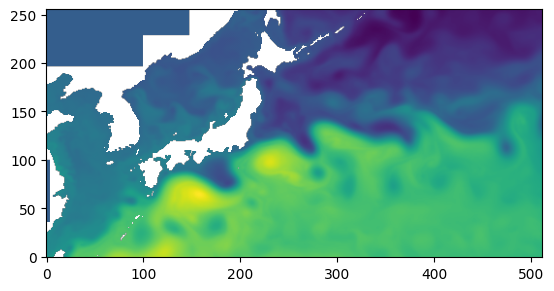

In [41]:
plt.imshow(test.isel(time = 0), origin = "lower")
plt.show()

**2.2 Repeat for all datasets**

**modify** and run bash script in screen 

<br>

./work/esn/CESM/chunk_all_files.sh

<br>

_this may take a few hours ... (~16h)_

take speacial care to change: 

- input/ output path 
- coordinates max/ min


and check here

In [42]:
original_file_path = f"/data/Hannah/{region}/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0041-12-27.nc"
ds = xr.open_dataset(original_file_path)

In [43]:
CESM_data_chunked = ds['SSH']

**Shape Check**

In [44]:
CESM_data_chunked.shape

(1, 256, 512)

**Sanity Check**

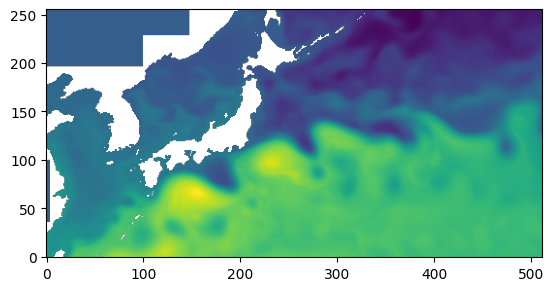

In [45]:
plt.imshow(CESM_data_chunked.isel(time = 0), origin = "lower")
plt.show()

#### **Step 3 - Regrid and interpolate**

SSH into TH02, start screen terminal

_actiate conda environment via_

<br>

source ~/miniconda3/bin/activate myenv

<br>

_cd to work/esn_ 

**modify region**

_run via_ 

<br>

python3 CESM/regridding.py

<br>


_wait..._

then check here 

In [46]:
CESM_data = np.load("Data/ssh_Kuro_new_2.npy")
lon = np.load("Data/lon_Kuro_new_2.npy")
lat = np.load("Data/lat_Kuro_new_2.npy")

**Shape Check**

In [47]:
CESM_data.shape

(2068, 256, 512)

**Sanity Check**

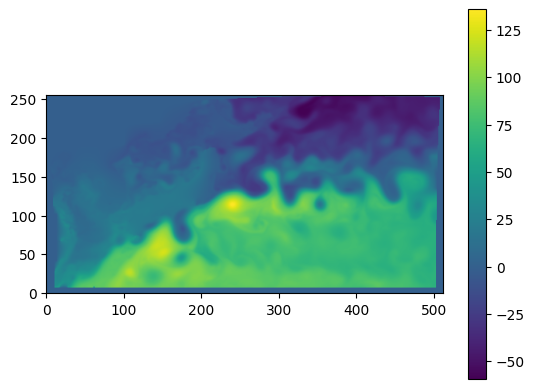

In [48]:
plt.imshow(CESM_data[0,:,:], origin="lower")
plt.colorbar()
plt.show()

**Sanity Check - nice** 

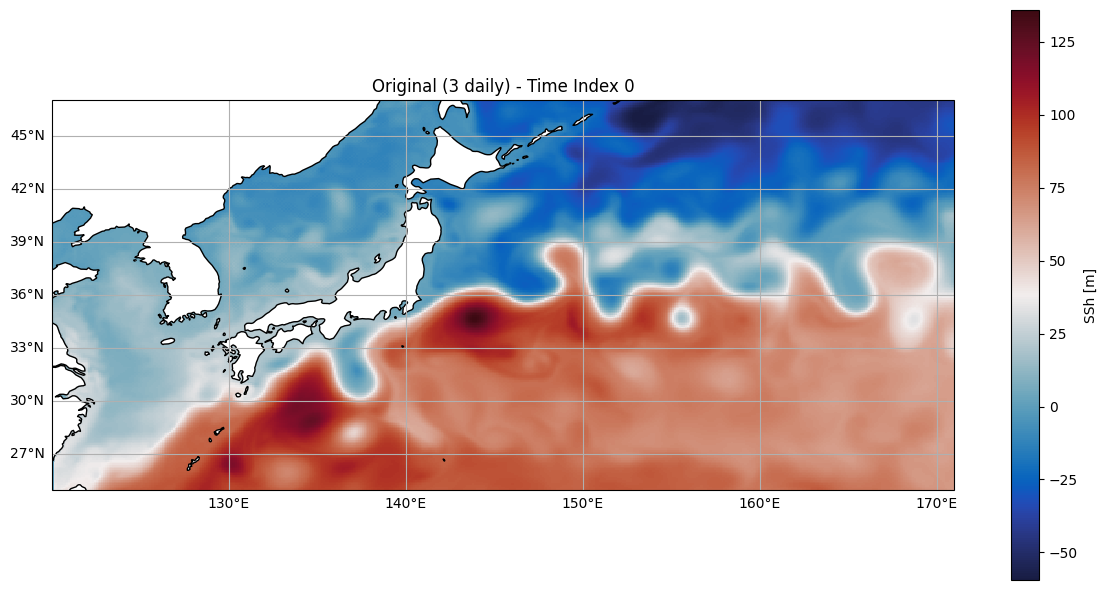

In [49]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
pcm = ax.pcolormesh(lon, lat, CESM_data[0,:,:], 
                    shading='auto', 
                    cmap=cmocean.cm.balance, 
                    transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, facecolor='white', zorder=1)
ax.coastlines()
ax.set_extent([lon.min() + 1, lon.max() - 1, lat.min() + 1, lat.max() - 1], crs=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

# Colorbar and title
plt.colorbar(pcm, ax=ax, orientation='vertical', label='SSh [m]')
ax.set_title('Original (3 daily) - Time Index 0')
plt.tight_layout()
plt.show()

#### **4. Resample & Detrend**

**4.1 Resample**

_Upsample to daily data_

In [50]:
nT_daily = CESM_data.shape[0] * 3  # since each point originally spans 3 days
CESM_data_daily = detrend.upscale(CESM_data, nT_daily)

_Downsample to 5-daily data_

In [51]:
CESM_data_five_daily = CESM_data_daily[::5]

In [52]:
np.save(f"Data/ssh_{region}_5d.npy", CESM_data_five_daily)

In [54]:
CESM_data_5d = np.load(f"Data/ssh_{region}_5d.npy")

**Shape Check**

In [55]:
CESM_data_5d.shape

(1241, 256, 512)

**Sanity Check**

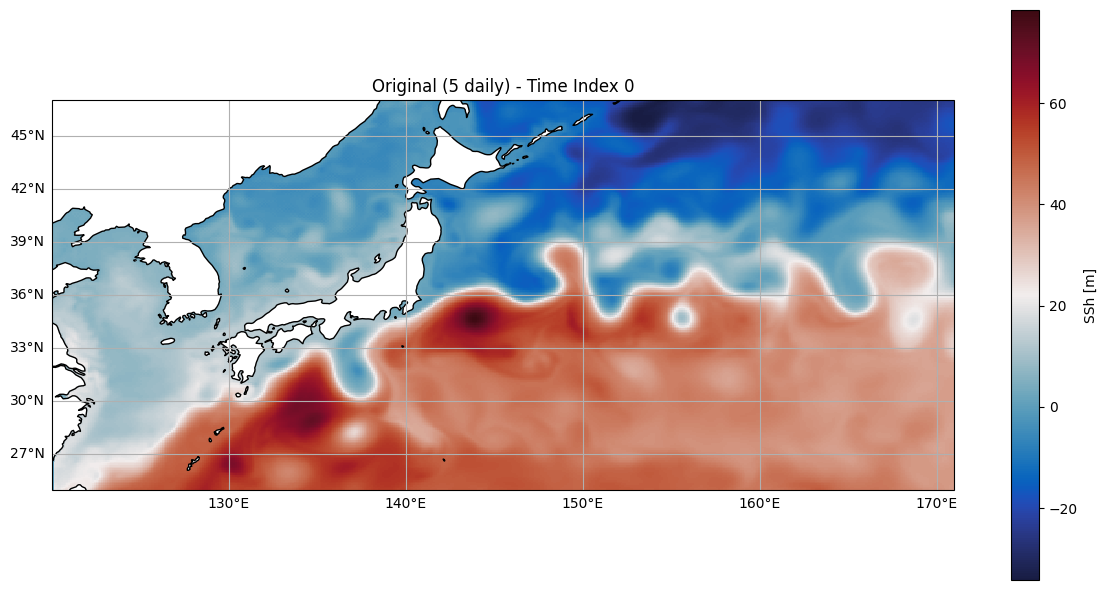

In [56]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
pcm = ax.pcolormesh(lon, lat, CESM_data_5d[0,:,:], 
                    shading='auto', 
                    cmap=cmocean.cm.balance, 
                    transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, facecolor='white', zorder=1)
ax.coastlines()
ax.set_extent([lon.min() + 1, lon.max() - 1, lat.min() + 1, lat.max() - 1], crs=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

# Colorbar and title
plt.colorbar(pcm, ax=ax, orientation='vertical', label='SSh [m]')
ax.set_title('Original (5 daily) - Time Index 0')
plt.tight_layout()
plt.show()

**4.2 Compute pol trend (using lsq)**

In [57]:
cycle_length = 73  # 365 days / 5-day spacing
ft_detrended, b, C = detrend.separate_trends_unscaled(CESM_data_five_daily, cycle_length)

In [58]:
np.save(f"Data/ssh_{region}_detrended.npy", ft_detrended)

In [59]:
CESM_data_detrended = np.load(f"Data/ssh_{region}_detrended.npy")

**Shape Check**

In [60]:
CESM_data_detrended.shape

(1241, 256, 512)

**Sanity Check**

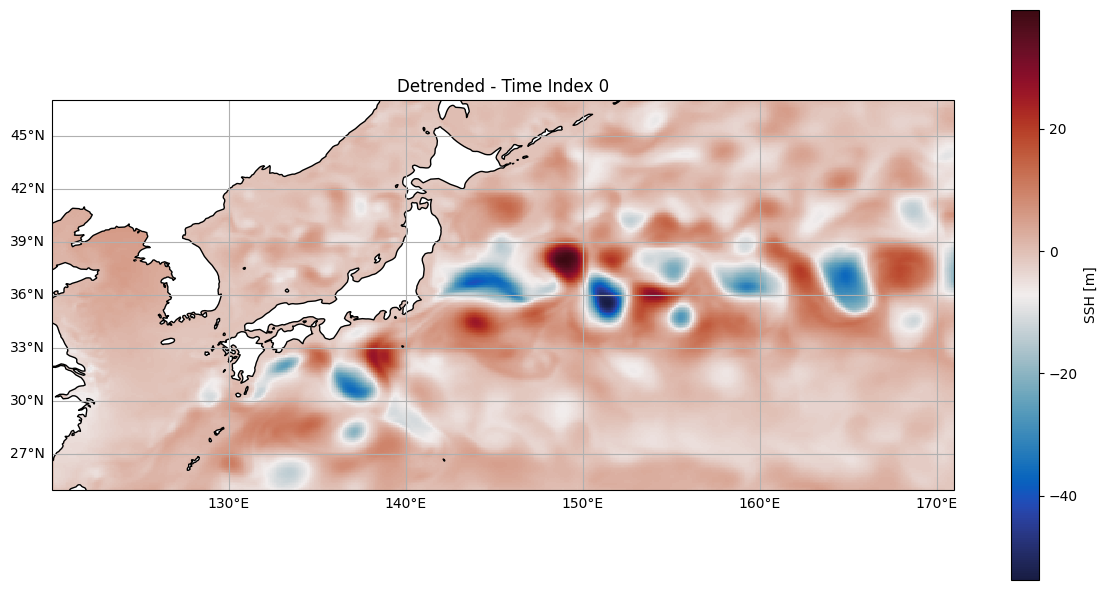

In [62]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
pcm = ax.pcolormesh(lon, lat, ft_detrended[0, :, :], 
                    shading='auto', 
                    cmap=cmocean.cm.balance, 
                    transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, facecolor='white', zorder=1)
ax.coastlines()
ax.set_extent([lon.min() + 1, lon.max() - 1, lat.min() + 1, lat.max() - 1], crs=ccrs.PlateCarree())

# Gridlines
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

# Colorbar and title
plt.colorbar(pcm, ax=ax, orientation='vertical', label='SSH [m]')
ax.set_title('Detrended - Time Index 0')
plt.tight_layout()
plt.show()